# Electricity Consumption Forecasting Problem for Tibber

**Disclaimer this notebook only reflects an exploratory work, this is not code at production quality**



In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import List
import numpy as np
from datetime import timedelta, datetime
from tensorflow import convert_to_tensor,keras,reshape # for building Neural Networks
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network
from keras.losses import MeanAbsolutePercentageError, MeanAbsoluteError
from sklearn.model_selection import train_test_split
from math import sqrt
from dataclasses import dataclass


## Data Exploration

In [2]:
# metadata, data = pickle.load(open("forecast_data_2020.p","rb")) # problem with pandas version ?
metadata, data = pd.read_pickle("forecast_data_2020.p")

In [3]:
print(metadata)

{'854': {'has_electric_vehicle': False}, '123': {'has_electric_vehicle': True}, '852': {'has_electric_vehicle': False}, '222': {'has_electric_vehicle': False}, '484': {'has_electric_vehicle': True}, '404': {'has_electric_vehicle': False}, '992': {'has_electric_vehicle': False}, '319': {'has_electric_vehicle': False}, '583': {'has_electric_vehicle': True}, '801': {'has_electric_vehicle': False}, '987': {'has_electric_vehicle': False}, '299': {'has_electric_vehicle': False}, '640': {'has_electric_vehicle': False}, '744': {'has_electric_vehicle': True}, '241': {'has_electric_vehicle': True}, '200': {'has_electric_vehicle': False}, '441': {'has_electric_vehicle': True}, '192': {'has_electric_vehicle': True}, '621': {'has_electric_vehicle': True}, '313': {'has_electric_vehicle': False}, '464': {'has_electric_vehicle': False}, '424': {'has_electric_vehicle': True}, '993': {'has_electric_vehicle': True}, '598': {'has_electric_vehicle': True}, '514': {'has_electric_vehicle': True}, '268': {'ha

In [4]:
display(data.head())
print(data.info())
data.describe()

854                                      \
                        temperature humidity cloudiness     consumption   
time                                                                      
2020-01-01 00:00:00  1.300000000000     71.0      100.0  4.711000000000   
2020-01-01 01:00:00  1.880000000000     71.0      100.0  6.294000000000   
2020-01-01 02:00:00  2.020000000000     73.0      100.0  4.587000000000   
2020-01-01 03:00:00  1.860000000000     75.0      100.0  4.246000000000   
2020-01-01 04:00:00  1.670000000000     75.0      100.0  4.642000000000   

                                123                                      \
                        temperature humidity cloudiness     consumption   
time                                                                      
2020-01-01 00:00:00  4.310000000000     72.0       99.0  4.127000000000   
2020-01-01 01:00:00  4.600000000000     73.0       99.0  4.148000000000   
2020-01-01 02:00:00  4.500000000000     75.0      100.0  3.828000000000   
2020-01-01 03:00:00  4.640000000000     75.0       96.0  4.375000000000   
2020-01-01 04:00:00  4.480000000000     75.0      100.0  4.622000000000   

                                852           ...        261                  \
                        temperature humidity  ... cloudiness     consumption   
time                                          ...                              
2020-01-01 00:00:00  2.110000000000     72.0  ...      100.0  6.581000000000   
2020-01-01 01:00:00  2.870000000000     72.0  ...      100.0  6.514000000000   
2020-01-01 02:00:00  2.980000000000     74.0  ...      100.0  6.544000000000   
2020-01-01 03:00:00  3.050000000000     75.0  ...      100.0  6.604000000000   
2020-01-01 04:00:00  2.660000000000     76.0  ...      100.0  5.809000000000   

                                957                                      \
                        temperature humidity cloudiness     consumption   
time                                                                      
2020-01-01 00:00:00  2.090000000000     68.0      100.0  1.480000000000   
2020-01-01 01:00:00  2.960000000000     69.0      100.0  2.260000000000   
2020-01-01 02:00:00  3.300000000000     71.0      100.0  1.900000000000   
2020-01-01 03:00:00  3.670000000000     73.0      100.0  2.020000000000   
2020-01-01 04:00:00  3.570000000000     73.0      100.0  1.380000000000   

                                600                                      
                        temperature humidity cloudiness     consumption  
time                                                                     
2020-01-01 00:00:00  1.570000000000     71.0      100.0  1.524000000000  
2020-01-01 01:00:00  2.250000000000     70.0      100.0  1.483000000000  
2020-01-01 02:00:00  2.440000000000     73.0      100.0  1.626000000000  
2020-01-01 03:00:00  2.330000000000     75.0      100.0  1.677000000000  
2020-01-01 04:00:00  2.140000000000     75.0      100.0  1.944000000000  

[5 rows x 400 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8809 entries, 2020-01-01 00:00:00 to 2021-01-01 00:00:00
Columns: 400 entries, ('854', 'temperature') to ('600', 'consumption')
dtypes: float64(200), object(200)
memory usage: 27.0+ MB
None


854                       123                       852  \
          humidity   cloudiness     humidity   cloudiness     humidity   
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000   
mean     74.743024    64.280554    74.841480    60.414406    74.320854   
std      20.014412    37.534896    17.254673    38.519414    19.733684   
min      12.000000     0.000000    25.000000     0.000000    17.000000   
25%      61.000000    30.000000    63.000000    21.000000    61.000000   
50%      80.000000    80.000000    78.000000    73.000000    79.000000   
75%      91.000000    99.000000    89.000000    98.000000    90.000000   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

                            222                       484               ...  \
        cloudiness     humidity   cloudiness     humidity   cloudiness  ...   
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000  ...   
mean     62.404881    76.136031    60.840969    73.703916    62.653162  ...   
std      38.266670    17.792208    39.122487    19.446567    38.338564  ...   
min       0.000000    22.000000     0.000000    15.000000     0.000000  ...   
25%      25.000000    64.000000    21.000000    60.000000    24.000000  ...   
50%      77.000000    80.000000    75.000000    78.000000    77.000000  ...   
75%      99.000000    90.000000    99.000000    90.000000   100.000000  ...   
max     100.000000   100.000000   100.000000   100.000000   100.000000  ...   

               890                       412                       261  \
          humidity   cloudiness     humidity   cloudiness     humidity   
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000   
mean     74.883914    63.645476    75.179669    63.715098    74.469656   
std      20.024912    37.858902    20.150818    38.034122    20.176689   
min      15.000000     0.000000    13.000000     0.000000    12.000000   
25%      61.000000    27.000000    61.000000    27.000000    61.000000   
50%      80.000000    79.000000    80.000000    80.000000    80.000000   
75%      91.000000    99.000000    92.000000    99.000000    91.000000   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

                            957                       600               
        cloudiness     humidity   cloudiness     humidity   cloudiness  
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000  
mean     63.605449    74.466330    63.379158    74.888137    63.733488  
std      37.715383    19.741193    37.766699    20.076438    37.796057  
min       0.000000    13.000000     0.000000    12.000000     0.000000  
25%      28.000000    61.000000    27.000000    61.000000    28.000000  
50%      79.000000    79.000000    79.000000    80.000000    79.000000  
75%      99.000000    90.000000    99.000000    91.000000    99.000000  
max     100.000000   100.000000   100.000000   100.000000   100.000000  

[8 rows x 200 columns]

### Declare convenience variables

In [5]:
houses=list(metadata.keys())
quantities=list(data.columns.get_level_values(1).unique())

### check that data and metadata are consistent

In [6]:
assert len(metadata) == len(data.columns.get_level_values(0).unique())
for house in metadata:
    assert house in data.columns.get_level_values(0)

### fix data type

In [7]:
data=data.astype(float)
data.describe()

854                                                 123  \
       temperature     humidity   cloudiness  consumption  temperature   
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000   
mean      7.868519    74.743024    64.280554     2.893879     9.479780   
std       7.071989    20.014412    37.534896     1.646711     6.259782   
min      -7.610000    12.000000     0.000000     0.259000    -4.700000   
25%       2.200000    61.000000    30.000000     1.626000     4.540000   
50%       6.750000    80.000000    80.000000     2.660000     8.390000   
75%      12.840000    91.000000    99.000000     3.935000    14.410000   
max      29.200000   100.000000   100.000000     9.882000    28.530000   

                                                      852               ...  \
          humidity   cloudiness  consumption  temperature     humidity  ...   
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000  ...   
mean     74.841480    60.414406     2.173687     8.811039    74.320854  ...   
std      17.254673    38.519414     1.699005     6.848627    19.733684  ...   
min      25.000000     0.000000     0.093000    -5.870000    17.000000  ...   
25%      63.000000    21.000000     0.825000     3.310000    61.000000  ...   
50%      78.000000    73.000000     1.794000     7.680000    79.000000  ...   
75%      89.000000    98.000000     3.147000    13.710000    90.000000  ...   
max     100.000000   100.000000     9.571000    30.430000   100.000000  ...   

               261                       957                            \
        cloudiness  consumption  temperature     humidity   cloudiness   
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000   
mean     63.605449     3.801180     7.825307    74.466330    63.379158   
std      37.715383     2.554304     6.646924    19.741193    37.766699   
min       0.000000     0.424000    -7.330000    13.000000     0.000000   
25%      28.000000     1.614000     2.680000    61.000000    27.000000   
50%      79.000000     3.125000     6.650000    79.000000    79.000000   
75%      99.000000     5.788000    12.540000    90.000000    99.000000   
max     100.000000    14.508000    28.500000   100.000000   100.000000   

                            600                                         
       consumption  temperature     humidity   cloudiness  consumption  
count  8809.000000  8809.000000  8809.000000  8809.000000  8809.000000  
mean      2.169117     8.023417    74.888137    63.733488     2.285638  
std       1.422068     6.973979    20.076438    37.796057     1.458101  
min       0.000000    -7.360000    12.000000     0.000000     0.533000  
25%       1.130000     2.460000    61.000000    28.000000     1.347000  
50%       1.760000     6.880000    80.000000    79.000000     1.770000  
75%       2.870000    12.940000    91.000000    99.000000     2.557000  
max      10.270000    29.340000   100.000000   100.000000     9.321000  

[8 rows x 400 columns]

### Investigate duplicates

In [8]:
data.index[data.index.duplicated()]

DatetimeIndex(['2020-09-07 22:00:00', '2020-09-07 23:00:00',
               '2020-09-08 00:00:00', '2020-09-08 01:00:00',
               '2020-09-08 02:00:00', '2020-09-08 03:00:00',
               '2020-09-08 04:00:00', '2020-09-08 05:00:00',
               '2020-09-08 06:00:00', '2020-09-08 07:00:00',
               '2020-09-08 08:00:00', '2020-09-08 09:00:00',
               '2020-09-08 10:00:00', '2020-09-08 11:00:00',
               '2020-09-08 12:00:00', '2020-09-08 13:00:00',
               '2020-09-08 14:00:00', '2020-09-08 15:00:00',
               '2020-09-08 16:00:00', '2020-09-08 17:00:00',
               '2020-09-08 18:00:00', '2020-09-08 19:00:00',
               '2020-09-08 20:00:00', '2020-09-08 21:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [9]:
for house in houses:
    for hour in data.index[data.index.duplicated()]:
        for q in quantities:
            if not data.loc[hour][(house,q)].duplicated().any(): print(house,hour,q)

925 2020-09-07 22:00:00 consumption
925 2020-09-07 23:00:00 consumption
925 2020-09-08 00:00:00 consumption
925 2020-09-08 01:00:00 consumption
925 2020-09-08 02:00:00 consumption
925 2020-09-08 03:00:00 consumption
925 2020-09-08 04:00:00 consumption
925 2020-09-08 05:00:00 consumption
925 2020-09-08 06:00:00 consumption
925 2020-09-08 07:00:00 consumption
925 2020-09-08 08:00:00 consumption
925 2020-09-08 09:00:00 consumption
925 2020-09-08 10:00:00 consumption
925 2020-09-08 11:00:00 consumption
925 2020-09-08 12:00:00 consumption
925 2020-09-08 13:00:00 consumption
925 2020-09-08 14:00:00 consumption
925 2020-09-08 15:00:00 consumption
925 2020-09-08 16:00:00 consumption
925 2020-09-08 17:00:00 consumption
925 2020-09-08 18:00:00 consumption
925 2020-09-08 19:00:00 consumption
925 2020-09-08 20:00:00 consumption
925 2020-09-08 21:00:00 consumption


In [10]:
data[data.index.duplicated(keep=False)]['925']

temperature  humidity  cloudiness  consumption
time                                                               
2020-09-07 22:00:00        10.46      84.0       100.0        0.390
2020-09-07 22:00:00        10.46      84.0       100.0        1.052
2020-09-07 23:00:00        11.12      84.0       100.0        0.322
2020-09-07 23:00:00        11.12      84.0       100.0        1.052
2020-09-08 00:00:00        11.58      84.0        94.0        0.381
2020-09-08 00:00:00        11.58      84.0        94.0        1.052
2020-09-08 01:00:00        11.23      85.0        68.0        0.426
2020-09-08 01:00:00        11.23      85.0        68.0        1.052
2020-09-08 02:00:00        10.63      86.0        41.0        0.515
2020-09-08 02:00:00        10.63      86.0        41.0        1.052
2020-09-08 03:00:00        10.31      85.0        23.0        1.445
2020-09-08 03:00:00        10.31      85.0        23.0        1.052
2020-09-08 04:00:00        10.19      84.0        24.0        4.603
2020-09-08 04:00:00        10.19      84.0        24.0        1.052
2020-09-08 05:00:00        10.30      82.0        37.0        1.403
2020-09-08 05:00:00        10.30      82.0        37.0        1.052
2020-09-08 06:00:00        10.79      82.0        51.0        0.230
2020-09-08 06:00:00        10.79      82.0        51.0        1.052
2020-09-08 07:00:00        12.11      76.0        64.0        0.000
2020-09-08 07:00:00        12.11      76.0        64.0        1.052
2020-09-08 08:00:00        13.81      64.0        78.0        0.000
2020-09-08 08:00:00        13.81      64.0        78.0        1.052
2020-09-08 09:00:00        15.28      55.0        86.0        0.000
2020-09-08 09:00:00        15.28      55.0        86.0        1.052
2020-09-08 10:00:00        16.69      48.0        88.0        0.000
2020-09-08 10:00:00        16.69      48.0        88.0        1.052
2020-09-08 11:00:00        18.06      44.0        84.0        0.000
2020-09-08 11:00:00        18.06      44.0        84.0        1.052
2020-09-08 12:00:00        19.41      41.0        77.0        0.000
2020-09-08 12:00:00        19.41      41.0        77.0        1.052
2020-09-08 13:00:00        20.34      39.0        69.0        0.000
2020-09-08 13:00:00        20.34      39.0        69.0        1.052
2020-09-08 14:00:00        19.99      39.0        59.0        0.000
2020-09-08 14:00:00        19.99      39.0        59.0        1.052
2020-09-08 15:00:00        18.08      43.0        51.0        0.000
2020-09-08 15:00:00        18.08      43.0        51.0        1.052
2020-09-08 16:00:00        17.11      46.0        52.0        0.000
2020-09-08 16:00:00        17.11      46.0        52.0        1.052
2020-09-08 17:00:00        15.77      51.0        56.0        0.000
2020-09-08 17:00:00        15.77      51.0        56.0        1.052
2020-09-08 18:00:00        14.58      56.0        54.0        0.000
2020-09-08 18:00:00        14.58      56.0        54.0        1.052
2020-09-08 19:00:00        13.61      59.0        42.0        0.000
2020-09-08 19:00:00        13.61      59.0        42.0        1.052
2020-09-08 20:00:00        12.76      62.0        25.0        0.000
2020-09-08 20:00:00        12.76      62.0        25.0        1.052
2020-09-08 21:00:00        12.03      66.0        14.0        0.000
2020-09-08 21:00:00        12.03      66.0        14.0        1.052

<AxesSubplot: xlabel='time'>

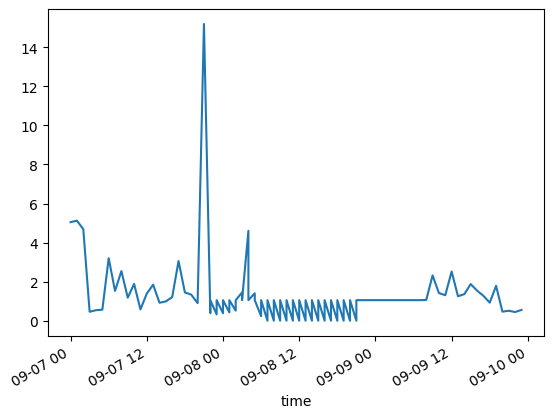

In [11]:
data.loc['2020-09-07':'2020-09-09'][('925','consumption')].plot()

### Clean Data

ideally one would develop a method to fix broken data instead of dropping it

In [12]:
cleanData=data.copy()
cleanData.loc[cleanData.index.duplicated(keep=False),('925','consumption')]=None
cleanData=cleanData.drop_duplicates()

In [13]:
assert (cleanData.asfreq('1H').index == cleanData.index).all()
cleanData=cleanData.asfreq('1H')

### Look for consumption "blocked" for several hours

define a function to identify when the consumption data is the same for two hours in a raw. This might happen by pure chance but houses where this happen often are likely to have a problem.

In [14]:
def powerMeterIsBlocked(df:pd.DataFrame)->List[bool]:
    assert 'consumption' in df.columns, f"consumption is expected to be in the columns of this dataframe"
    return list(df.iloc[0:-1]['consumption'].values-df.iloc[1:]['consumption'].values == 0)
for house in houses:
    blocked=powerMeterIsBlocked(cleanData[house])
    if any(blocked):
        print(f"House {house} has {len(cleanData[blocked+[False]][(house,'consumption')])} consecutive hours with the same consumption")

House 854 has 21 consecutive hours with the same consumption
House 123 has 48 consecutive hours with the same consumption
House 852 has 19 consecutive hours with the same consumption
House 222 has 78 consecutive hours with the same consumption
House 484 has 13 consecutive hours with the same consumption
House 404 has 13 consecutive hours with the same consumption
House 992 has 14 consecutive hours with the same consumption
House 319 has 12 consecutive hours with the same consumption
House 583 has 14 consecutive hours with the same consumption
House 801 has 23 consecutive hours with the same consumption
House 987 has 15 consecutive hours with the same consumption
House 299 has 37 consecutive hours with the same consumption
House 640 has 10 consecutive hours with the same consumption
House 744 has 15 consecutive hours with the same consumption
House 241 has 11 consecutive hours with the same consumption
House 200 has 21 consecutive hours with the same consumption
House 441 has 10 consecu

### Aggregating all houses

Let's see at how much the data varies from one house to another

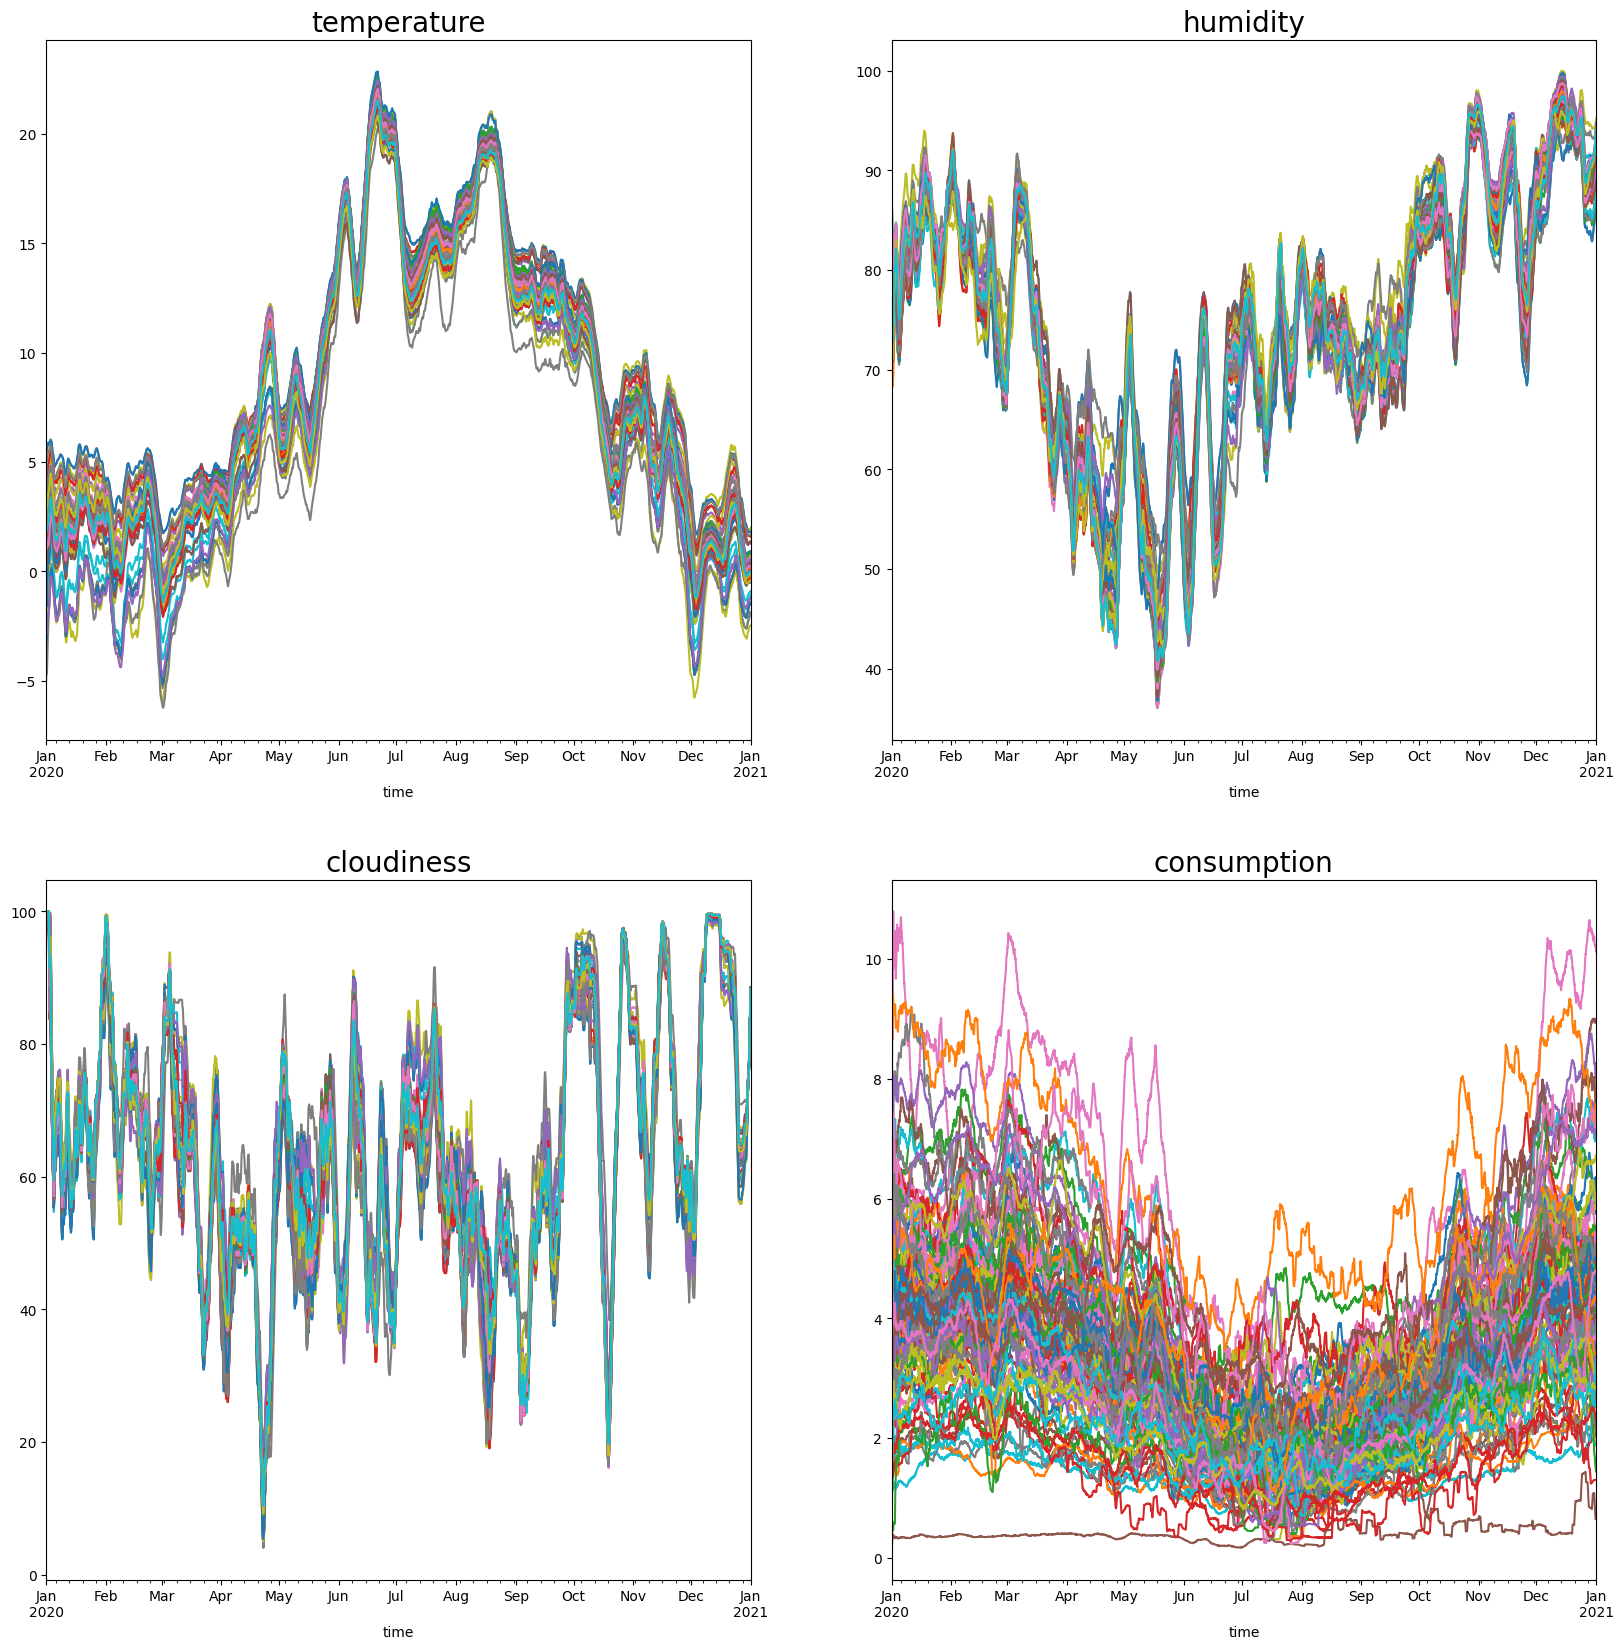

In [15]:
fig=plt.figure(figsize=(20,20))
gs = fig.add_gridspec(2,2)
ax={}
k=0
for quantity in quantities:
    ax[quantity] = fig.add_subplot(gs[int(k/2), k%2])
    ax[quantity].set_title(quantity,fontsize=20)
    cleanData.loc[:,(slice(None),quantity)].rolling(timedelta(days=7)).mean().plot(ax=ax[quantity],legend=False)
    k+=1
plt.show()


## First approach: average over portfolio

It seems that the weather data does not vary considerably from one house to another. The consumption fluctuates much more but we are only interested in the total consumption. As a first attempt, we can try to model the entire portfolio with aggregated data

<AxesSubplot: xlabel='time'>

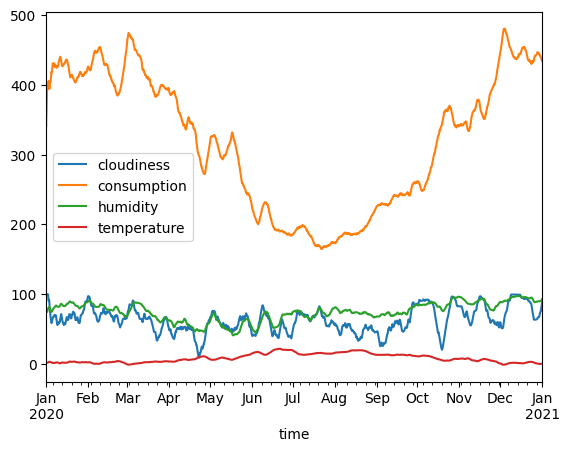

In [16]:
portfolio=cleanData.groupby(axis=1,level=1).mean()
portfolio.consumption=portfolio.consumption*len(houses) # to get the sum
portfolio.rolling(timedelta(days=7)).mean().plot()

In [17]:
portfolio.consumption.max()
MAX_CONSUMPTION=700

In [18]:
portfolio.consumption.mean()

319.5303980556849

### Feature normalisation

This is not really necessary for humidity and cloudiness but it probably helps for temperature and consumption. One should note hower that the upper and lower values for temperature and consumption are arbitrary and should be changed (or at least checked) when new data comes in

In [19]:
def normaliseInputs(df:pd.DataFrame)->pd.DataFrame:
    quantities=['temperature','humidity','cloudiness','consumption']
    assert all([col in quantities for col in df.columns]), f"{df.columns} does not contain the expected qunatities"
    tmin,tmax=(-20,40)
    assert df.temperature.min()>=tmin, f"The data contains temperature lower than {tmin}°C"
    assert df.temperature.max()<=tmax, f"The data contains temperature higher than {tmax}°C"
    cmin,cmax=(0,MAX_CONSUMPTION)
    assert df.temperature.min()>=tmin, f"The data contains consumption lower than {cmin}kWh"
    assert df.temperature.max()<=tmax, f"The data contains consumption higher than {cmax}kWh"
    newdf=df.copy()
    newdf.humidity=newdf.humidity/100
    newdf.cloudiness=newdf.cloudiness/100
    newdf.temperature=(newdf.temperature-tmin)/(tmax-tmin)
    newdf.consumption=(newdf.consumption-cmin)/(cmax-cmin)
    return newdf

In [20]:
normalisedPortfolio=normaliseInputs(portfolio)


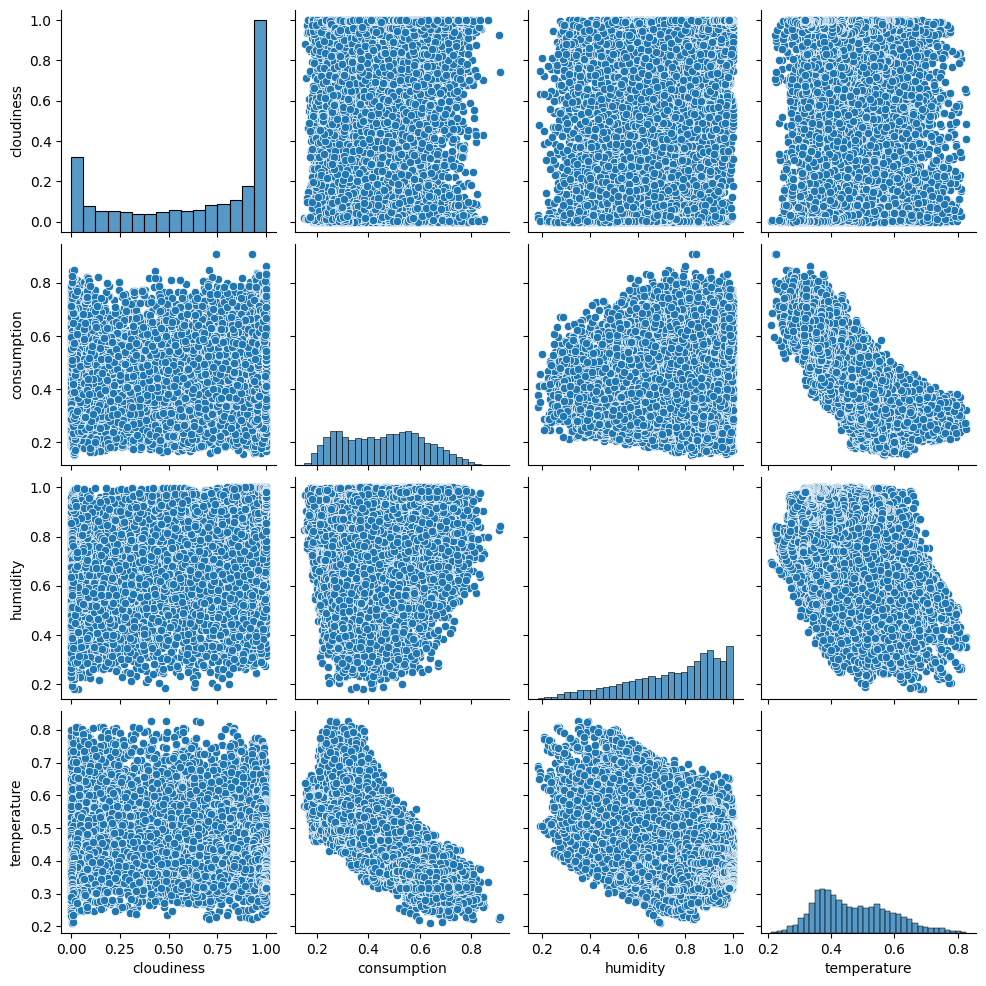

In [21]:
sns.pairplot(normalisedPortfolio)

In [22]:
normalisedPortfolio.corr()

cloudiness  consumption  humidity  temperature
cloudiness     1.000000     0.168547  0.443768    -0.113653
consumption    0.168547     1.000000  0.213804    -0.772622
humidity       0.443768     0.213804  1.000000    -0.408485
temperature   -0.113653    -0.772622 -0.408485     1.000000

It seems that there is a good correlation between consumption and temperature. The relevance of cloudiness and humidity is not straightforward. We will keep these features for now but one should probably try to extract a more relevant information or drop them alltogether.

### Simple Gated Reccurent Unit model

Simple Gated Reccurent Unit (GRU) are good models for many-to-one prediction models but they are far from being the only ones. This choice is simply for exploration's sake and demonstrating feasibility

#### Feature preparation

The model will be provided with at least 24h of consumption data (D-1) and weather data for (D+1)
The output is the consumption for (D+1)

It is possible to 
* provide more past data for consumption (D-2, D-3 etc) 
* provide past weather data (D, D-1) 
* also predict consumption for D 
by changing δtInput,horizonStart and horizonEnd but some combinations would result in shapes not necessarily compatible as is with the Keras model and would then require some reshaping.

In [23]:
def createFeatures(df:pd.DataFrame,δtInput:timedelta=timedelta(hours=24),
                   horizonStart:timedelta=timedelta(days=2),
                   horizonEnd:timedelta=timedelta(days=3))->(List[List[float]],List[float]):
    inputs=np.array([])
    outputs=np.array([])
    t1=df.index[0]
    batchNumber=0
    keptQuantities=["temperature","cloudiness","humidity"]
    #keptQuantities=["temperature"]
    while t1+horizonEnd<=df.index[-1]:
        if any(powerMeterIsBlocked(df.loc[t1:t1+δtInput-timedelta(hours=1),["consumption"]])) or \
            any(powerMeterIsBlocked(df.loc[t1+horizonStart:t1+horizonEnd-timedelta(hours=1),["consumption"]])):
            continue
        batchNumber+=1
        features=df.loc[t1:t1+δtInput-timedelta(hours=1),["consumption"]].reset_index(drop=True)
        features=pd.concat([features,df.loc[t1+horizonStart:t1+horizonEnd-timedelta(hours=1),keptQuantities].reset_index(drop=True)],axis=1)
        features.to_numpy()
        prediction=df.loc[t1+horizonStart:t1+horizonEnd-timedelta(hours=1),["consumption"]]
        prediction.to_numpy()
        if t1==df.index[0]:
            inputs=features
            outputs=prediction
        else:
            inputs=np.concatenate((inputs,features),axis=0)
            outputs=np.concatenate((outputs,prediction),axis=0)
        t1+=timedelta(hours=24)#δtInput#timedelta(hours=24)
    inputs=np.reshape(inputs, (batchNumber, int(δtInput.total_seconds()/3600), 1+len(keptQuantities)))
    outputs=np.reshape(outputs, (batchNumber, int((horizonEnd-horizonStart).total_seconds()/3600)))
    assert inputs.shape[0]==outputs.shape[0]
    return (inputs,outputs)

In [24]:
inputs,outputs=createFeatures(normalisedPortfolio,timedelta(hours=48),horizonEnd=timedelta(days=4))
print(inputs.shape,outputs.shape)

(363, 48, 4) (363, 48)


### Pipeline definition

we define the pipeline as a dataclass that takes a pandas DataFrame, creates the input and output arryas (using the above function), split the data set in training and testing sets, define the losses, the model. The class also has methods to train and display performance of the model.

The losses are slightly modified so they are only applied on the last 24h (D+1) of the prediction, in the current case it does not change anything but it is useful if one wants to also predict consumption of the current day but not take it into account in the loss function (as it does not affect our business case)

The model consists of two bi-directional GRU units with a repeat vector (only really needed when the input and the output sizes do not match). Bi-directionality is questionable here but seems to give good result. Further work should however be done to test its relevance.

In [25]:
@dataclass
class pipeline:
    dataDF:pd.DataFrame
    def __post_init__(self):
        self.createInputOutput()
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
            self.inputs,
            self.outputs,
            test_size=0.2,
            shuffle=False,
            random_state=123 # For reproduceability. Should be removed in the future
            ) ## Split data into train and test dataframes
        self.X_train=convert_to_tensor(self.X_train)
        self.X_test=convert_to_tensor(self.X_test)
        self.Y_train=convert_to_tensor(self.Y_train)
        self.Y_test=convert_to_tensor(self.Y_test)
        self.defineModel()
        self.compileModel()
    def createInputOutput(self):
        self.inputs,self.outputs=createFeatures(self.dataDF)#,timedelta(hours=48),horizonEnd=timedelta(days=4))
    def last24hMAPE(self,y_true,y_pred):
        mape=MeanAbsolutePercentageError()
        return mape(y_true[:,-24:],y_pred[:,-24:])
    def last24hMAE(self,y_true,y_pred):
        mae=MeanAbsoluteError()
        return mae(y_true[:,-24:],y_pred[:,-24:])
    def defineModel(self):
        self.model = Sequential(name="GRU-Model") # Model
        self.model.add(Input(shape=(self.X_train.shape[1],self.X_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
        self.model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
        self.model.add(RepeatVector(self.X_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
        self.model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
        self.model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x
    def compileModel(self):
        self.model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              #loss='MeanAbsolutePercentageError', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              loss=self.last24hMAPE,
              metrics=['MeanSquaredError', 'MeanAbsoluteError','MeanAbsolutePercentageError',self.last24hMAE], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None,#[0 for _ in range(24)]+[1 for _ in range(24)], # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )
    def trainModel(self):
        self.history = self.model.fit(x=self.X_train, # input data
                    y=self.Y_train, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=50, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    #validation_data=(self.X_test, self.Y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=10, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )
    def performance(self):
        pred_test = self.model.predict(self.X_test)
        print('-------------------- Evaluation on Training Data --------------------')
        for item in self.history.history:
            print("Final", item, ":", self.history.history[item][-1])
        print("")

        # Evaluate the model on the test data using "evaluate"
        print('-------------------- Evaluation on Test Data --------------------')
        results = self.model.evaluate(self.X_test, self.Y_test)
        print("")
        print(f"MAPE: {results[0]:.2f}%")
        return results

In [26]:
allDataAggregated=pipeline(normalisedPortfolio)
allDataAggregated.trainModel()

2022-11-07 08:14:08.291515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-07 08:14:08.291539: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-07 08:14:08.291553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (td): /proc/driver/nvidia/version does not exist
2022-11-07 08:14:08.291794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
232/232 [==============================] - 4s 6ms/step - loss: 19.0855 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0797 - mean_absolute_percentage_error: 19.0855 - last24hMAE: 0.0797
Epoch 2/50
232/232 [==============================] - 1s 6ms/step - loss: 14.5972 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0605 - mean_absolute_percentage_error: 14.5972 - last24hMAE: 0.0605
Epoch 3/50
232/232 [==============================] - 1s 6ms/step - loss: 13.5520 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0573 - mean_absolute_percentage_error: 13.5520 - last24hMAE: 0.0573
Epoch 4/50
232/232 [==============================] - 1s 6ms/step - loss: 13.5210 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0569 - mean_absolute_percentage_error: 13.5210 - last24hMAE: 0.0569
Epoch 5/50
232/232 [==============================] - 1s 6ms/step - loss: 13.5655 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0568 - mean_absolute_percentage_error: 13.5655 -

In [27]:
allDataAggregated.model.summary() # print model summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 64)               7296      
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 24, 64)           0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 24, 64)           18816     
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 24, 1)            65        
 ed)                                                             
                                                                 
Total params: 26,177
Trainable params: 26,177
Non-trainab

In [28]:
resultsAllDataAggregated=allDataAggregated.performance()

3/3 [==============================] - 1s 6ms/step
-------------------- Evaluation on Training Data --------------------
Final loss : 8.122245788574219
Final mean_squared_error : 0.0020708173979073763
Final mean_absolute_error : 0.034686241298913956
Final mean_absolute_percentage_error : 8.122245788574219
Final last24hMAE : 0.034686241298913956
Final val_loss : 9.203019142150879
Final val_mean_squared_error : 0.0018095184350386262
Final val_mean_absolute_error : 0.03369544818997383
Final val_mean_absolute_percentage_error : 9.203019142150879
Final val_last24hMAE : 0.03369544818997383

-------------------- Evaluation on Test Data --------------------
3/3 [==============================] - 1s 6ms/step - loss: 7.8850 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0459 - mean_absolute_percentage_error: 7.8850 - last24hMAE: 0.0498

MAPE: 7.88%


In [29]:
print(f"MAE: {resultsAllDataAggregated[4]*MAX_CONSUMPTION:.2f}kWh ~ {100*resultsAllDataAggregated[2]*MAX_CONSUMPTION/portfolio.consumption.mean():.2f}% of mean")

MAE: 34.87kWh ~ 10.05% of mean


### Splitting houses with and without EVs

Because we have aggregated the entire portfolio, we did not take advantage of the metadata provided. Let's now check if it makes sense to train two different models for the two classes of houses, with or without EV

In [30]:
housesWithEV=[house for house in houses if metadata[house]['has_electric_vehicle']]
housesWithoutEV=[house for house in houses if not metadata[house]['has_electric_vehicle']]
print(len(housesWithEV),len(housesWithoutEV))

66 34


EV      noEV
time                                   
2020-01-01 00:00:00  3.411076  3.436471
2020-01-01 01:00:00  3.381545  3.363588
2020-01-01 02:00:00  3.571667  3.556118
2020-01-01 03:00:00  3.689879  3.706147
2020-01-01 04:00:00  3.704167  3.465382
...                       ...       ...
2020-12-31 20:00:00  4.278212  4.105618
2020-12-31 21:00:00  3.934333  3.736882
2020-12-31 22:00:00  3.827545  3.609176
2020-12-31 23:00:00  3.723818  3.571206
2021-01-01 00:00:00  3.903955  3.635735

[8785 rows x 2 columns]

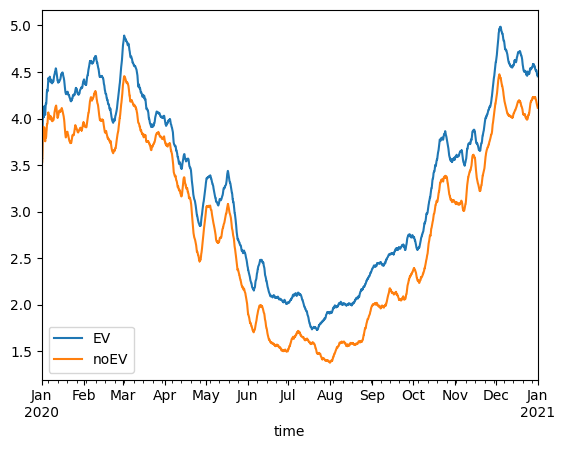

In [31]:
df=pd.concat([cleanData[housesWithEV].groupby(axis=1,level=1).mean().consumption,\
        cleanData[housesWithoutEV].groupby(axis=1,level=1).mean().consumption],axis=1)
df.columns=['EV','noEV']
display(df)
ax=df.rolling(timedelta(days=7)).mean().plot()

<AxesSubplot: xlabel='time'>

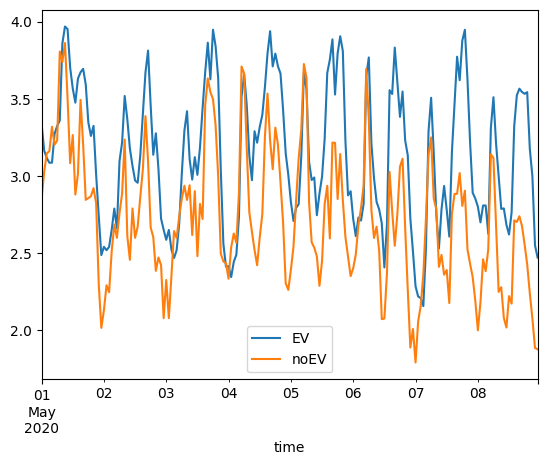

In [32]:
df["2020-05-01":"2020-05-08"].plot()

In [33]:
EVs=cleanData[housesWithEV].groupby(axis=1,level=1).mean()
EVs.consumption=EVs.consumption*len(housesWithEV)
EVs=normaliseInputs(EVs)
EVAggregated=pipeline(EVs)
EVAggregated.trainModel()

Epoch 1/50
232/232 [==============================] - 5s 8ms/step - loss: 27.2633 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0750 - mean_absolute_percentage_error: 27.2633 - last24hMAE: 0.0750
Epoch 2/50
232/232 [==============================] - 2s 8ms/step - loss: 16.4962 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0467 - mean_absolute_percentage_error: 16.4962 - last24hMAE: 0.0467
Epoch 3/50
232/232 [==============================] - 2s 8ms/step - loss: 15.3585 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0438 - mean_absolute_percentage_error: 15.3585 - last24hMAE: 0.0438
Epoch 4/50
232/232 [==============================] - 2s 8ms/step - loss: 15.1753 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0433 - mean_absolute_percentage_error: 15.1753 - last24hMAE: 0.0433
Epoch 5/50
232/232 [==============================] - 2s 8ms/step - loss: 13.9312 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 13.9312 -

In [34]:
resultsEVAggregated=EVAggregated.performance()

3/3 [==============================] - 1s 6ms/step
-------------------- Evaluation on Training Data --------------------
Final loss : 9.467612266540527
Final mean_squared_error : 0.0012559358729049563
Final mean_absolute_error : 0.027430713176727295
Final mean_absolute_percentage_error : 9.467612266540527
Final last24hMAE : 0.027430713176727295
Final val_loss : 18.151935577392578
Final val_mean_squared_error : 0.003401038935407996
Final val_mean_absolute_error : 0.04863230511546135
Final val_mean_absolute_percentage_error : 18.151935577392578
Final val_last24hMAE : 0.04863230511546135

-------------------- Evaluation on Test Data --------------------
3/3 [==============================] - 1s 6ms/step - loss: 11.3301 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 11.3301 - last24hMAE: 0.0446

MAPE: 11.33%


In [35]:
noEVs=cleanData[housesWithoutEV].groupby(axis=1,level=1).mean()
noEVs.consumption=EVs.consumption*len(housesWithoutEV)
noEVs=normaliseInputs(noEVs)
noEVAggregated=pipeline(noEVs)
noEVAggregated.trainModel()

Epoch 1/50
232/232 [==============================] - 5s 9ms/step - loss: 321.0300 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 321.0300 - last24hMAE: 0.0411
Epoch 2/50
232/232 [==============================] - 2s 9ms/step - loss: 184.4593 - mean_squared_error: 9.9279e-04 - mean_absolute_error: 0.0237 - mean_absolute_percentage_error: 184.4593 - last24hMAE: 0.0237
Epoch 3/50
232/232 [==============================] - 2s 9ms/step - loss: 161.3206 - mean_squared_error: 6.8870e-04 - mean_absolute_error: 0.0208 - mean_absolute_percentage_error: 161.3206 - last24hMAE: 0.0208
Epoch 4/50
232/232 [==============================] - 2s 8ms/step - loss: 98.1381 - mean_squared_error: 2.3373e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 98.1381 - last24hMAE: 0.0120
Epoch 5/50
232/232 [==============================] - 2s 9ms/step - loss: 115.8427 - mean_squared_error: 3.5297e-04 - mean_absolute_error: 0.0146 - mean_absolute_perc

In [36]:
resultsnoEVAggregated=noEVAggregated.performance()

3/3 [==============================] - 1s 7ms/step
-------------------- Evaluation on Training Data --------------------
Final loss : 13.580072402954102
Final mean_squared_error : 5.304150818119524e-06
Final mean_absolute_error : 0.0018113378901034594
Final mean_absolute_percentage_error : 13.580072402954102
Final last24hMAE : 0.0018113378901034594
Final val_loss : 11.23287296295166
Final val_mean_squared_error : 3.17897161039582e-06
Final val_mean_absolute_error : 0.001403206610120833
Final val_mean_absolute_percentage_error : 11.23287296295166
Final val_last24hMAE : 0.001403206610120833

-------------------- Evaluation on Test Data --------------------
3/3 [==============================] - 1s 8ms/step - loss: 9.9571 - mean_squared_error: 5.6381e-06 - mean_absolute_error: 0.0019 - mean_absolute_percentage_error: 9.9571 - last24hMAE: 0.0018

MAPE: 9.96%


In [37]:
print(f"MAE portfolio: {MAX_CONSUMPTION*sqrt(resultsEVAggregated[4]**2+resultsnoEVAggregated[4]**2):.2f}kWh ~ {100*MAX_CONSUMPTION*(resultsEVAggregated[2]+resultsnoEVAggregated[2])/portfolio.consumption.mean():.2f}% of mean")

MAE portfolio: 31.27kWh ~ 10.31% of mean


### Splitting houses with and witout electric heating

another way to split the houses is to try to guess whether or not they use electrical heating, which is expected to be much more weather dependent. Since we do not have the data, let's make the assumption that the houses that consume considerably more during winter than in summer, are those using electrical heating

In [38]:
def seasonality(df):
    monthlyAverage=df.groupby(by=df.index.month).mean()
    return monthlyAverage.max()/monthlyAverage.min()

<AxesSubplot: ylabel='Frequency'>

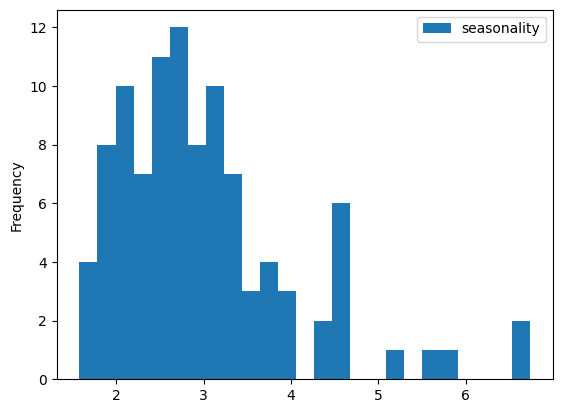

In [39]:
consoSeasonality=pd.DataFrame(data=[seasonality(cleanData[h].consumption) for h in houses],index=houses,columns=["seasonality"])
bins=25
consoSeasonality.plot.hist(bins=bins)
#consoSeasonality.loc[[x in housesWithEV for x in consoSeasonality.index]].plot.hist(bins=bins)
#consoSeasonality.loc[[x in housesWithoutEV for x in consoSeasonality.index]].plot.hist(bins=bins)

It looks like there are two population with seasonality larger or smaller than **2.5** (it may as well be a simple statistical glimpse but let's give it a try.

In [40]:
seasonalityLimit=2.5
housesElectricalHeating=[h for h in houses if consoSeasonality.loc[h,"seasonality"]>seasonalityLimit]
housesWithoutElectricalHeating=[h for h in houses if consoSeasonality.loc[h,"seasonality"]<=seasonalityLimit]

print(len(housesElectricalHeating),len(housesWithoutElectricalHeating))

66 34


In [41]:
heating=cleanData[housesElectricalHeating].groupby(axis=1,level=1).mean()
heating.consumption=heating.consumption*len(housesElectricalHeating)
heating=normaliseInputs(heating)
heatingAggregated=pipeline(heating)
heatingAggregated.trainModel()

Epoch 1/50
232/232 [==============================] - 5s 10ms/step - loss: 27.4115 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0703 - mean_absolute_percentage_error: 27.4115 - last24hMAE: 0.0703
Epoch 2/50
232/232 [==============================] - 2s 9ms/step - loss: 19.7800 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0499 - mean_absolute_percentage_error: 19.7800 - last24hMAE: 0.0499
Epoch 3/50
232/232 [==============================] - 2s 9ms/step - loss: 16.7266 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0444 - mean_absolute_percentage_error: 16.7266 - last24hMAE: 0.0444
Epoch 4/50
232/232 [==============================] - 2s 9ms/step - loss: 16.0130 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 16.0130 - last24hMAE: 0.0424
Epoch 5/50
232/232 [==============================] - 2s 9ms/step - loss: 16.8031 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0447 - mean_absolute_percentage_error: 16.8031 

In [42]:
resultsHeatingAggregated=heatingAggregated.performance()

3/3 [==============================] - 1s 6ms/step
-------------------- Evaluation on Training Data --------------------
Final loss : 9.287406921386719
Final mean_squared_error : 0.001059538684785366
Final mean_absolute_error : 0.025029631331562996
Final mean_absolute_percentage_error : 9.287406921386719
Final last24hMAE : 0.025029631331562996
Final val_loss : 10.489635467529297
Final val_mean_squared_error : 0.0011286544613540173
Final val_mean_absolute_error : 0.02587832510471344
Final val_mean_absolute_percentage_error : 10.489635467529297
Final val_last24hMAE : 0.02587832510471344

-------------------- Evaluation on Test Data --------------------
3/3 [==============================] - 1s 6ms/step - loss: 7.9849 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 7.9849 - last24hMAE: 0.0326

MAPE: 7.98%


In [43]:
noHeating=cleanData[housesWithoutElectricalHeating].groupby(axis=1,level=1).mean()
noHeating.consumption=heating.consumption*len(housesWithoutElectricalHeating)
noHeating=normaliseInputs(noHeating)
noHeatingAggregated=pipeline(noHeating)
noHeatingAggregated.trainModel()

Epoch 1/50
232/232 [==============================] - 5s 9ms/step - loss: 338.2011 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 338.2011 - last24hMAE: 0.0382
Epoch 2/50
232/232 [==============================] - 2s 9ms/step - loss: 161.6070 - mean_squared_error: 5.2529e-04 - mean_absolute_error: 0.0182 - mean_absolute_percentage_error: 161.6070 - last24hMAE: 0.0182
Epoch 3/50
232/232 [==============================] - 2s 9ms/step - loss: 157.8278 - mean_squared_error: 6.1668e-04 - mean_absolute_error: 0.0182 - mean_absolute_percentage_error: 157.8278 - last24hMAE: 0.0182
Epoch 4/50
232/232 [==============================] - 2s 9ms/step - loss: 101.4612 - mean_squared_error: 2.3277e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 101.4612 - last24hMAE: 0.0110
Epoch 5/50
232/232 [==============================] - 2s 9ms/step - loss: 84.9256 - mean_squared_error: 1.5411e-04 - mean_absolute_error: 0.0094 - mean_absolute_per

In [44]:
resultsNoHeatingAggregated=noHeatingAggregated.performance()

3/3 [==============================] - 1s 7ms/step
-------------------- Evaluation on Training Data --------------------
Final loss : 15.794120788574219
Final mean_squared_error : 6.242854851734592e-06
Final mean_absolute_error : 0.0019426866201683879
Final mean_absolute_percentage_error : 15.794120788574219
Final last24hMAE : 0.0019426866201683879
Final val_loss : 12.379169464111328
Final val_mean_squared_error : 2.835816076185438e-06
Final val_mean_absolute_error : 0.0013292512157931924
Final val_mean_absolute_percentage_error : 12.379169464111328
Final val_last24hMAE : 0.0013292512157931924

-------------------- Evaluation on Test Data --------------------
3/3 [==============================] - 1s 7ms/step - loss: 11.1201 - mean_squared_error: 6.9278e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 11.1201 - last24hMAE: 0.0021

MAPE: 11.12%


In [45]:
print(f"MAE portfolio: {MAX_CONSUMPTION*sqrt(resultsHeatingAggregated[4]**2+resultsNoHeatingAggregated[4]**2):.2f}kWh ~ {100*700*(resultsHeatingAggregated[2]+resultsNoHeatingAggregated[2])/portfolio.consumption.mean():.2f}% of mean")

MAE portfolio: 22.86kWh ~ 7.51% of mean


### Summary

| Approach                                     | MAE [kWh] | MAPE [%] |
|----------------------------------------------|-----------|-----------|
| Single model                                 |    34.9   | 7.9 |
| Differentiating according to EV possession   |    31.3   | |
| Differentiating according to heating system  |    22.9   | |

<!-- | Approach -48h                                | MAE [kWh] | MAPE [%] |
|----------------------------------------------|-----------|-----------|
| Single model                                 |    37     | 8.56 |
| Differentiating according to EV possession   |    25.8   | |
| Differentiating according to heating system  |    23.2   | |
 -->

as a comparision the hourly consumption average is 320kWh
<!-- 
| Approach -24h                                | MAE [kWh] | MAPE [%] |
|----------------------------------------------|-----------|-----------|
| Single model                                 |    35   | 8.26 |
| Differentiating according to EV possession   |    25   | |
| Differentiating according to heating system  |    32   | |

 -->


## Discussion

### Business questions

1. is the relative mean absolute error the best loss function for the problem? Using relative errors implies that doing a 1kWh error is worse when the total consumption is low than when it is high. But is it really the case? The cost of an error of 1kWh can be translated in cash loss using the day ahead price → a loss function better reflecting the business case would improve the model.

### How to improve the model

1. refactor the code so that train/test split is done before the category splits → more categories, total MRAE
1. better assess the input features (only mean or other aggregations?), role of humidity and cloudiness
1. tune the model hyper-parameters (there is some over-fitting)
1. improve the split between electrical heating / no electrical heating
1. infer houses in the same weather area and train one model per region (? only if enough houses)
1. introduce the price as an input feature (?) and in the loss function
1. improve the code so it can be generalised to different horizons and actually calculate the 48h of prediction

### Other approaches

1. model the houses individually → very time consumming not necessarily smaller error
1. other algorithms (LSTM)

## Bonus question:
```
Let's say one home has electric heating that you can control automatically. How would
you model and schedule the heater to save money for the homeowner assuming they have
hourly energy prices?
● What kind of data would you need to implement your solution (e.g. variables,
granularity)?
● How would you trigger the computation of the controlling schedule?
```

1. data needed: 
    1. time-series (~every 15'')
        1. heater on/off
        1. indoor temperature
        1. outdoor temperature
        1. day-ahead price (hourly)
    1. categorical data
        1. type of heater (recommended minimum cycle)
  
1. Calculation
    1. model the house
        1. estimate the time needed to increase/decrease the temperature
        1. set a range of acceptable temperature
    1. trajectory algorithm
        1. build an objective function from price and temperature
        1. break the period for which there is price information into a number of cycle (_e.g._ 15')
        1. create a random walk that keeps the temperature within the acceptable temperature range → calculate the total cost → restart → find a minimum (Markov Chain Monte Carlo, genetic algorithm...)
1. Application
    1. every day at 12:45 when day-ahead price are published, calculate the best trajectory until the following day at midnight
    1. every cycle, if the temperature mismatches the one of the trajectory, recalculate a new trajectory
    1. add some overwrites
        1. read the starting temperature → heat until back in range
        1. Try to estimate if windows are open → turn off heating
